In [171]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# If the node is outside the query range
if query_rect[1] < root.left_rectangle[0] or query_rect[0] > root.right_rectangle[1]:
    return canonical_nodes

# If the node is completely inside the query range, canonical node
if query_rect[0] <= root.left_rectangle[0] and query_rect[1] >= root.right_rectangle[1]:
    canonical_nodes.append(root)
    return canonical_nodes

# Check if the right node is a leaf
if root.right_child.datapoint is not None:
    leaf = root.right_child
    if query_rect[0] <= leaf.datapoint.coordinate <= query_rect[1]:
        canonical_nodes.append(leaf)
# Else check that the right node is in the query range
elif root.right_rectangle[0] <= query_rect[0] <= root.right_rectangle[1] or root.right_rectangle[0] <= query_rect[1] <= root.right_rectangle[1]:
    canonical_nodes.extend(self.__query_canonical(root.right_child, query_rect))
# Else check that the right node is completely inside the query range
elif root.right_rectangle[0] >= query_rect[0] and root.right_rectangle[1] <= query_rect[1]:
    canonical_nodes.extend(self.__query_canonical(root.right_child, query_rect))

# Check if left node is a leaf
if root.left_child.datapoint is not None:
    leaf = root.left_child
    if query_rect[0] <= leaf.datapoint.coordinate <= query_rect[1]:
        canonical_nodes.append(leaf)
# Else check that the left node is partially in the query range
elif root.left_rectangle[0] <= query_rect[0] <= root.left_rectangle[1] or root.left_rectangle[0] <= query_rect[1] <= root.left_rectangle[1]:
    canonical_nodes.extend(self.__query_canonical(root.left_child, query_rect))
# Else check that the left node is completely inside the query range
elif root.left_rectangle[0] >= query_rect[0] and root.left_rectangle[1] <= query_rect[1]:
    canonical_nodes.extend(self.__query_canonical(root.left_child, query_rect))

In [763]:
class Datapoint:
    def __init__(self, coordinate, color, **kwargs):
        assert isinstance(coordinate, list), 'Coordinate must be a list of integers'
        assert isinstance(color, str)
        self.coordinate = coordinate
        self.color = color
        self.kwargs = kwargs

class Node:
    def __init__(self, weight = 0, children = 0, color=None, rect_1=None, rect_2=None, dp: Datapoint=None, **kwargs):
        self.left_rectangle: list[int] or None = rect_1
        self.right_rectangle: list[int] or None = rect_2
        self.datapoint: Datapoint or None = dp
        self.left_child: Node or None = None
        self.right_child: Node or None = None
        self.color: str or None = color
        self.weight = weight
        self.children = children
        self.kwargs = kwargs

class KDTree:
    def __init__(self):
        self.root: Node or None = None
        self.dimension: int = 0
        self.level1: dict[str: float] = dict()
        self.colors: dict[str: float] or None = None
        self.twod_root: Node or None = None
    
    def __calculate_probs(self, weights: list[float]) -> list[float]:
        ai = list()
        for weight in weights:
            ai.append(self.__single_prob(weight))
        return ai
    
    def __single_prob(self, weight) -> float:
        return random.random() ** (1/weight)
    
    def __add_color(self, color: str):
        if color not in self.level1:
            self.level1[color] = self.__single_prob(self.colors[color])
            
    def __twod_transformation(self, points: list[Datapoint]):
        points.sort(key=lambda  p: p.coordinate)
        colors = dict()
        twod_points = list()
        for p in points:
            value = -10
            if p.color in colors:
                value = colors[p.color]
            colors[p.color] = p.coordinate[0]
            twod_point = Datapoint([p.coordinate[0], value], p.color)
            twod_points.append(twod_point)
        return twod_points
    
    def __can_nodes_break(self, nodes):
        if len(nodes) == 1:
            if nodes[0].datapoint is not None:
                return nodes[0].color
            else:
                n = [nodes[0].left_child, nodes[0].right_child]
                return self.__can_nodes_break(n)
        else:
            weights = [self.colors[i.color] for i in nodes]
            ai = self.__calculate_probs(weights)
            index_max = np.argmax(ai)
            n = [nodes[index_max]]
            return self.__can_nodes_break(n)
        
    def level2_random_selection(self, rectangle: list, points: list[Datapoint]):
        if self.twod_root is None:
            twod_points = self.__twod_transformation(points)
            self.twod_root = self.__build_tree(twod_points)
        can_nodes = self.__query_canonical(self.twod_root, rectangle)
        if len(can_nodes) == 0:
            return can_nodes, self.twod_root
        return self.__can_nodes_break(can_nodes)
            
    def level1_random_selection(self, rectangle: list) -> str:
        c_nodes = self.query_canonical(rectangle)
        weights = [self.level1[node.color] for node in c_nodes]
        index_max = np.argmax(weights)
        return c_nodes[index_max].color

    def build_tree(self, points: list[Datapoint], colors: dict[str: float]):
        assert len(points) > 0, 'There must be at least one datapoint to build tree'
        assert len(points[0].coordinate), 'The coordinate must have at least one dimension'
        self.dimension = len(points[0].coordinate)
        self.colors = colors
        self.root = self.__build_tree(points)

    def __build_tree(self, points: list[Datapoint]) -> Node or None:
        if len(points) == 0:
            return None
        if len(points) == 1:
            color_1 = points[0].color
            self.__add_color(color_1)
            return Node(dp=points[0], color=color_1, weight=self.colors[color_1])
        if len(points) == 2:
            points.sort(key=lambda pts: pts.coordinate)
            
            if len(points[0].coordinate) == 1:
                r_1 = [[points[0].coordinate[0], points[0].coordinate[0]],[points[0].coordinate[0], points[0].coordinate[0]]]
            else: 
                r_1 = [points[0].coordinate, points[0].coordinate]
            if len(points[1].coordinate) == 1:
                r_2 = [[points[1].coordinate[0], points[1].coordinate[0]],[points[1].coordinate[0], points[1].coordinate[0]]]
            else:
                r_2 = [points[1].coordinate, points[1].coordinate]
                
            color_1 = points[0].color
            color_2 = points[1].color
            self.__add_color(color_1)
            self.__add_color(color_2)
            if self.level1[color_1] >= self.level1[color_2]:
                root_color = color_1
            else:
                root_color = color_2

            root = Node(rect_1=r_1, rect_2=r_2, color=root_color, children=2, weight=self.colors[color_1]+self.colors[color_2])
            root.left_child = Node(dp=points[0], color=color_1, weight=self.colors[color_1])
            root.right_child = Node(dp=points[1], color=color_2, weight=self.colors[color_2])
            return root
        
        coordinates = np.array([p.coordinate for p in points])
        variances = np.var(coordinates, axis=0)
        index_max_variance = np.argmax(variances)
        points.sort(key=lambda pts: pts.coordinate[index_max_variance])
        median_index = len(points) // 2
        root = Node(children=len(points))
        p1 = points[:median_index]
        p2 = points[median_index:]
        p1.sort(key=lambda pts: pts.coordinate)
        p2.sort(key=lambda pts: pts.coordinate)
        if p1[0].coordinate <= p2[0].coordinate:
            root.left_child = self.__build_tree(p1)
            root.right_child = self.__build_tree(p2)
        else:
            root.left_child = self.__build_tree(p2)
            root.right_child = self.__build_tree(p1)
        
        if root.right_child.datapoint is not None:
            r_1 = root.right_child.datapoint.coordinate
            if len(r_1) == 1:
                root.right_rectangle = [[r_1[0], r_1[0]] , [r_1[0], r_1[0]]]
            else:    
                root.right_rectangle = [r_1 , r_1]
        else:
            right_child = root.right_child
            min_l = np.min(right_child.left_rectangle + right_child.right_rectangle, axis=0)
            max_r = np.max(right_child.left_rectangle + right_child.right_rectangle, axis=0)

            r_1 = [min_l[0], min_l[1]]
            r_2 = [max_r[0], max_r[1]]
            
            root.right_rectangle = [r_1, r_2]
            
        if root.left_child.datapoint is not None:
            r_1 = root.left_child.datapoint.coordinate
            if len(r_1) == 1:
                root.left_rectangle = [[r_1[0], r_1[0]] , [r_1[0], r_1[0]]]
            else:
                root.left_rectangle = [r_1 , r_1]
        else:
            left_child = root.left_child
            min_l = np.min(left_child.left_rectangle + left_child.right_rectangle, axis=0)
            max_r = np.max(left_child.left_rectangle + left_child.right_rectangle, axis=0)
            
            r_1 = [min_l[0], min_l[1]]
            r_2 = [max_r[0], max_r[1]]
            
            root.left_rectangle = [r_1, r_2]  
        
        color_1 = root.left_child.color
        color_2 = root.right_child.color
        if self.level1[color_1] >= self.level1[color_2]:
            root_color = color_1
        else:
            root_color = color_2
        
        root.weight = root.left_child.weight + root.right_child.weight
        root.color = root_color
        return root
    
    def query_canonical(self, rectangle: list):
        assert len(rectangle) == 2, f'There must be two coordinates to draw a query rectangle'
        assert isinstance(rectangle[0], list) and isinstance(rectangle[0], list), 'Each coordinate must be in the format of a list'
        assert len(rectangle[0]) == self.dimension and len(rectangle[1]) == self.dimension, f'Expected dimension of rectangle to be {self.dimension}'
        assert rectangle[0] <= rectangle[1], 'Invalid query rectangle'
        return self.__query_canonical(self.root, rectangle)

    def __rectangles_intersect(self, root_rectangle, query_rectangle):
        for dim in range(len(query_rectangle[0])):
            if root_rectangle[0][dim] > query_rectangle[1][dim] or query_rectangle[0][dim] > root_rectangle[1][dim]:
                return False
        return True
    
    def __query_canonical(self, root: Node or None, query_rect: list) -> list[Node]:
        canonical_nodes : list[Node] = list()
        if root is None:
            return canonical_nodes
        
        if root.datapoint is not None:
            if np.all(np.array(query_rect[0]) <= np.array(root.datapoint.coordinate)) and np.all( np.array(root.datapoint.coordinate) <= np.array(query_rect[1])):
                canonical_nodes.append(root)
            return canonical_nodes

        
        if np.all(np.array(query_rect[0]) <= np.array(root.left_rectangle[0])) and np.all(np.array(query_rect[1]) >= np.array(root.right_rectangle[1])):
            canonical_nodes.append(root)
            return canonical_nodes
        
        if self.__rectangles_intersect(root.left_rectangle, query_rect):
            canonical_nodes.extend(self.__query_canonical(root.left_child, query_rect))

        if self.__rectangles_intersect(root.right_rectangle, query_rect):
            canonical_nodes.extend(self.__query_canonical(root.right_child, query_rect))
        
            
        return canonical_nodes
        
        

In [764]:
data_colors = {str(i): random.uniform(1,10) for i in range(1, 201)}

datapoints = [Datapoint([random.randint(1, 100), random.randint(1, 100)], color=random.choice( list(data_colors.keys()) ) ) for i in range(100)]

In [765]:
tree = KDTree()
tree.build_tree(datapoints, data_colors)
datapoints.sort(key=lambda pts: pts.coordinate)

In [766]:
test3_colors = {str(i): 1 for i in range(1,3)}
test3_datapoints = [Datapoint([i], color='1') for i in range(1, 7)]
test3_datapoints[2].color = '2'
test3_datapoints[3].color = '2'
test3_datapoints[4].color = '2'
test3_tree = KDTree()
test3_tree.build_tree(test3_datapoints, test3_colors)

In [767]:
x = test3_tree.level2_random_selection( ([1.5, -10], [6.5, 1.4]), test3_datapoints )
x

'1'

In [797]:
test1_colors = {str(i): (500/np.exp(0.5 * i)) for i in range(1, 11)}
test1_datapoints = [Datapoint([i], color= str( ( (i-1)%10 ) + 1 ) )for i in range(1, 1001)]
test1_tree = KDTree()
test1_tree.build_tree(test1_datapoints, test1_colors)

In [798]:
test1_result = {str(i): 0 for i in range(1, 11)}
for i in range(1000):
    x = test1_tree.level2_random_selection( ([40.5, -10], [83.5, 40.4]), test1_datapoints )
    test1_result[x] = test1_result[x] + 1

In [799]:
test1_result

{'1': 444,
 '2': 276,
 '3': 148,
 '4': 62,
 '5': 31,
 '6': 19,
 '7': 8,
 '8': 5,
 '9': 5,
 '10': 2}

Text(0.5, 1.0, 'Test1')

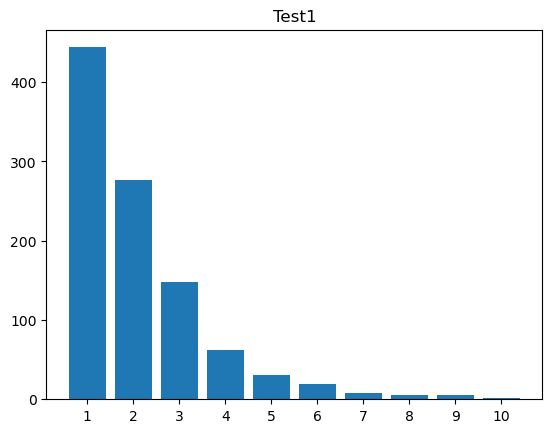

In [805]:
plt.bar(test1_result.keys(), test1_result.values())
plt.title('Test1')

In [801]:
test2_colors = {str(i): (500/np.exp(0.5 * i)) for i in range(1, 11)}
test2_colors['0'] = 100000000
test2_datapoints = [Datapoint([i], color= '1') for i in range(1, 1001)]
for i in range(1000):
    if i < 40 or i > 82:
        test2_datapoints[i].color = str(1)
    elif i <= 43:
        test2_datapoints[i].color = str(i-39)
    elif i < 78:
        test2_datapoints[i].color = '5'
    else:
        test2_datapoints[i].color = str(88-i)
   
test2_tree = KDTree()
test2_tree.build_tree(test2_datapoints, test2_colors)

In [802]:
test2_result = {str(i): 0 for i in range(1, 11)}
for i in range(1000):
    x = test2_tree.level2_random_selection( ([40.5, -10], [83.5, 40.4]), test2_datapoints )
    test2_result[x] = test2_result[x] + 1

In [803]:
test2_result

{'1': 607,
 '2': 218,
 '3': 84,
 '4': 39,
 '5': 20,
 '6': 16,
 '7': 11,
 '8': 3,
 '9': 1,
 '10': 1}

Text(0.5, 1.0, 'Test2')

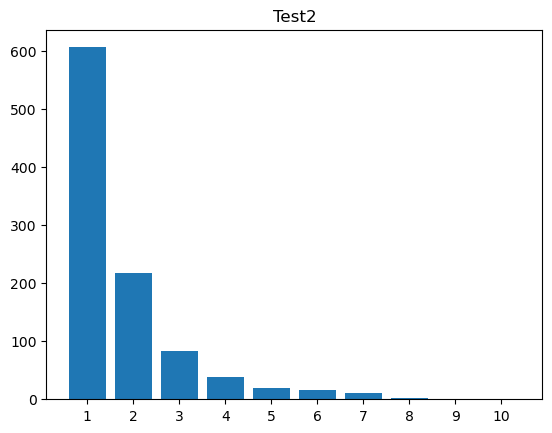

In [806]:
plt.bar(test2_result.keys(), test2_result.values())
plt.title('Test2')

In [105]:
def break_nodes(node):
    if node.datapoint is not None:
        print('leaf: ', node.datapoint.coordinate, c.color)
    else:
        break_nodes(node.left_child)
        break_nodes(node.right_child)

In [106]:
if len(x) > 0:
    for c in x:
        if c.datapoint is not None:
            print('leaf: ', c.datapoint.coordinate, c.color)
        else:
            break_nodes(c.left_child)
            break_nodes(c.right_child)
else:
    print('Empty')

leaf:  [4, 3] 1
leaf:  [5, 4] 1
leaf:  [6, 2] 1
leaf:  [2, 1] 1
leaf:  [3, -10] 1


In [65]:
c_nodes = tree.query_canonical( ([31, 56], [50, 3]) )
if len(c_nodes) > 0:
    for c in c_nodes:
        if c.datapoint is not None:
            print('leaf: ', c.datapoint.coordinate, c.children, c.color, tree.level1[c.color])
        else:
            print('node: ', c.left_rectangle, c.right_rectangle, c.children, c.color, tree.level1[c.color])
else:
    print('Empty')

leaf:  [49, 17] 0 121 0.9169433622069816
node:  [[46, 25], [46, 25]] [[48, 38], [48, 38]] 2 187 0.9711908110409186
leaf:  [36, 33] 0 68 0.7665256485660252
leaf:  [44, 4] 0 63 0.8496730862570708
node:  [[37, 63], [37, 63]] [[43, 53], [48, 55]] 3 192 0.8469708772516646
node:  [[31, 58], [31, 58]] [[35, 56], [35, 56]] 2 91 0.9910650756180903
node:  [[33, 91], [36, 90]] [[45, 87], [46, 85]] 4 113 0.8711047045084136


In [77]:
x = c_nodes[6]

[406, 260, 130, 81, 47, 32, 22, 10, 7, 5]

In [156]:
x.weight

NEW INSTANCE
[1, -10] 0
[2, 1] 0
[3, 2] 0
[4, 3] 0
[5, 4] 0
[6, 5] 0
[7, 6] 0
[8, 7] 0
[9, 8] 0
[10, 9] 0
[11, 10] 0
[12, 11] 0
[13, 12] 0
[14, 13] 0
[15, 14] 0
[16, 15] 0
[17, 16] 0
[18, 17] 0
[19, 18] 0
[20, 19] 0
[21, 20] 0
[22, 21] 0
[23, 22] 0
[24, 23] 0
[25, 24] 0
[26, 25] 0
[27, 26] 0
[28, 27] 0
[29, 28] 0
[30, 29] 0
[31, 30] 0
[32, 31] 0
[33, 32] 0
[34, 33] 0
[35, 34] 0
[36, 35] 0
[37, 36] 0
[38, 37] 0
[39, 38] 0
[40, 39] 0
[84, 40] 0
[85, 84] 0
[86, 85] 0
[87, 86] 0
[88, 87] 0
[89, 88] 0
[90, 89] 0
[91, 90] 0
[92, 91] 0
[93, 92] 0
[94, 93] 0
[95, 94] 0
[96, 95] 0
[97, 96] 0
[98, 97] 0
[99, 98] 0
[100, 99] 0
[101, 100] 0
[102, 101] 0
[103, 102] 0
[104, 103] 0
[105, 104] 0
[106, 105] 0
[107, 106] 0
[108, 107] 0
[109, 108] 0
[110, 109] 0
[111, 110] 0
[112, 111] 0
[113, 112] 0
[114, 113] 0
[115, 114] 0
[116, 115] 0
[117, 116] 0
[118, 117] 0
[119, 118] 0
[120, 119] 0
[121, 120] 0
[122, 121] 0
[123, 122] 0
[124, 123] 0
[125, 124] 0
[126, 125] 0
[127, 126] 0
[128, 127] 0
[129, 128] 0

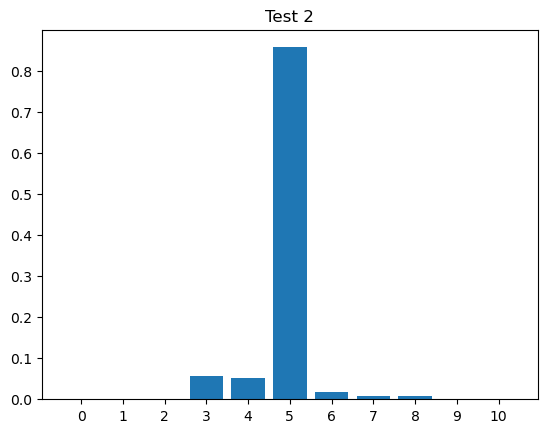

In [157]:
x.left_child.weight

In [158]:
x.right_child.weight

In [59]:
tree.level1_random_selection(([34, 56], [38, 3]))

leaf:  [19, 17] 0 13 1.4219119762258092e-07
leaf:  [19, -10] 0 38 0.24231215645929707
node:  [[18, -10], [18, -10]] [[19, -10], [19, -10]] 2 27 0.015385547438700577
node:  [[1, -10], [6, -10]] [[8, -10], [17, -10]] 5 1 0.13017994576240105


In [188]:
for datapoint in datapoints:
    print(datapoint.coordinate)

[1, 47]
[2, 17]
[2, 59]
[2, 85]
[3, 23]
[4, 71]
[4, 78]
[5, 7]
[5, 38]
[6, 16]
[8, 87]
[10, 98]
[11, 68]
[11, 86]
[12, 36]
[12, 37]
[13, 65]
[14, 17]
[16, 54]
[16, 70]
[16, 71]
[16, 97]
[19, 90]
[23, 11]
[23, 49]
[23, 72]
[25, 50]
[27, 37]
[27, 91]
[28, 41]
[30, 62]
[30, 81]
[33, 50]
[33, 95]
[34, 24]
[34, 79]
[34, 83]
[35, 9]
[35, 17]
[35, 86]
[35, 94]
[35, 97]
[37, 44]
[37, 55]
[38, 85]
[39, 7]
[39, 74]
[39, 81]
[41, 64]
[41, 74]
[43, 1]
[46, 73]
[46, 96]
[48, 34]
[49, 13]
[52, 8]
[52, 20]
[52, 45]
[55, 16]
[55, 49]
[56, 12]
[56, 78]
[58, 9]
[60, 64]
[60, 66]
[61, 97]
[62, 4]
[63, 72]
[67, 10]
[67, 49]
[67, 56]
[69, 7]
[69, 73]
[70, 29]
[71, 10]
[74, 54]
[75, 41]
[75, 46]
[76, 48]
[78, 5]
[78, 56]
[78, 65]
[80, 37]
[80, 46]
[82, 9]
[83, 48]
[87, 68]
[91, 68]
[91, 94]
[92, 17]
[92, 53]
[92, 77]
[93, 31]
[93, 41]
[95, 36]
[96, 25]
[96, 84]
[97, 18]
[99, 91]
[100, 44]


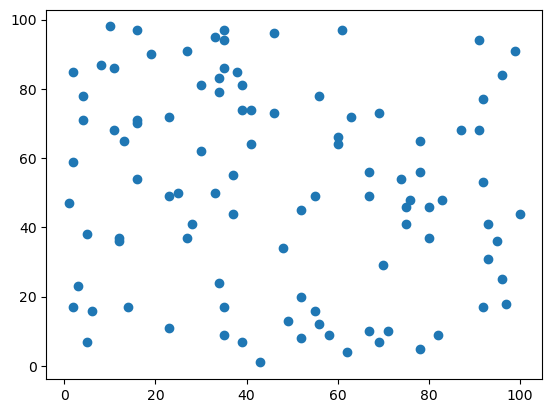

In [189]:
# Let's say we have the following list of coordinates:
crds = [dp.coordinate for dp in datapoints]

# We can separate these into two lists of x and y coordinates using the zip function:
x, y = zip(*crds)

# Now we can create a scatter plot of these coordinates:
plt.scatter(x, y)

# And finally display the plot:
plt.show()


In [190]:
def is_balanced(root):
    def check(node):
        if node is None:
            return 0
        left = check(node.left_child)
        right = check(node.right_child)
        if left == -1 or right == -1 or abs(left - right) > 1:
            return -1
        return 1 + max(left, right)

    return check(root) != -1

is_balanced(tree.root)

True